# Исследование по метрикам на основе данных моего произношения

## Импорт библиотеки

In [1]:
# Импорт библиотеки
import sys
import os
import re
import numpy as np
# Метрики
from jiwer import wer, cer, mer, wil
# Расстояние Левенштейна
import Levenshtein

import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

import io
import soundfile as sf
import librosa

import nltk
import string
from nltk.stem import WordNetLemmatizer

from AutomaticSpeechRecognitionYandex import AutomaticSpeechRecognitionYandex
from AutomaticSpeechRecognitionSaluteSpeech import AutomaticSpeechRecognitionSaluteSpeech
from AutomaticSpeechRecognitionMBART50 import AutomaticSpeechRecognitionMBART50

from tokens import FOLDER_ID, OAUTH, CLIENT_ID, CLIENT_SECRET

## Загрузка данных с БД

In [2]:
# Сбор список слов
from sentences_text import sentences_text

### Коллекция слов

In [3]:
for theme, words in sentences_text.items():
    print(f"Тема: {theme}")
    print("Предложение:", words)
    print("\n")

Тема: Искусственный интеллект
Предложение: Искусственный интеллект (ИИ) - это область компьютерных наук, создающая системы для выполнения задач, требующих человеческого интеллекта: распознавание речи, обработка изображений, принятие решений. Искусственный интеллект проникает во все сферы жизни, от рекомендаций в онлайн-магазинах до медицинских диагнозов.

Главное преимущество ИИ - способность обрабатывать большие объемы данных и выявлять закономерности. В медицине он помогает диагностировать заболевания, анализируя снимки и историю болезни. В бизнесе искусственный интеллект используется для прогнозирования рынка, оптимизации цепочек поставок и автоматизации процессов.

ИИ базируется на алгоритмах машинного обучения, позволяющих системам обучаться на основе данных. Современные ИИ-системы используют глубокие нейронные сети, имитирующие работу мозга. Для разработки таких моделей требуются мощные вычислительные ресурсы и инструменты, такие как TensorFlow и PyTorch.

Искусственный интеллект

### Подключение к БД

In [4]:
%%time
# Соединение с БД
conn = psycopg2.connect(
    host="localhost",
    port="5432",
    database="asr_text",
    user="postgres",
    password="postgres"
)
cur = conn.cursor()

CPU times: user 3.87 ms, sys: 1.21 ms, total: 5.08 ms
Wall time: 11.4 ms


In [5]:
%%time
# Получение данных из таблицы
cur.execute("SELECT * FROM audio_records")
data = cur.fetchall()

CPU times: user 265 ms, sys: 302 ms, total: 567 ms
Wall time: 670 ms


In [6]:
%%time
# Закрытие соединения
cur.close()
conn.close()

CPU times: user 534 µs, sys: 153 µs, total: 687 µs
Wall time: 489 µs


### Создание и анализ датафрейма

In [7]:
# Создание DataFrame из полученных данных
df = pd.DataFrame(data, columns=['id', 'topic', 'paragraph_text', 'transcript_text_yandex', 'transcript_text_salutespeech', 'transcript_text_mbart50', 'voice_recording', 'record_date'])

In [8]:
# Преобразование столбца record_date в формат datetime
df['record_date'] = pd.to_datetime(df['record_date'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461 entries, 0 to 460
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            461 non-null    int64         
 1   topic                         461 non-null    object        
 2   paragraph_text                461 non-null    object        
 3   transcript_text_yandex        461 non-null    object        
 4   transcript_text_salutespeech  461 non-null    object        
 5   transcript_text_mbart50       461 non-null    object        
 6   voice_recording               461 non-null    object        
 7   record_date                   461 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 28.9+ KB


In [10]:
df.head()

,id,topic,paragraph_text,transcript_text_yandex,transcript_text_salutespeech,transcript_text_mbart50,voice_recording,record_date
0,5,Искусственный интеллект,Искусственный интеллект - революционная технол...,Рвотчины технари мнящие мир и проносящие на че...,"Эффект революционный техногии, меняющий мир, п...","они киллект, революция, тихонги, мне очень яны...","[b'O', b'g', b'g', b'S', b'\x00', b'\x02', b'\...",2024-06-15
1,13,Веб-сокет,Веб-сокеты - мощный инструмент для разработки ...,Веб секрет мощный интернет для разработки веб ...,Рен постояние 3 направлений сидни и низкая за...,"ведь все-таки, тёмненький интеллигент, проживш...","[b'O', b'g', b'g', b'S', b'\x00', b'\x02', b'\...",2024-06-16
2,14,Плавание,"Плавание - это вид спорта и активного отдыха, ...",Прямо на этой битве спорят и активисты выходят...,"Про мне это вид спорт и активный. Выходи, закл...","про мне эти видосы, и активные охоты и закруча...","[b'O', b'g', b'g', b'S', b'\x00', b'\x02', b'\...",2024-06-16
3,23,Технологическая сингулярность,"Технологическая сингулярность - это теория, пр...",Процессорывающий момент когда интеллект провод...,Проводит человеческий интеллект и технологии ...,"— из-вторых, неверность этот яры, протягивающи...","[b'O', b'g', b'g', b'S', b'\x00', b'\x02', b'\...",2024-06-16
4,38,Плавание,Существует несколько стилей плавания с разными...,Как ровными техническими осипшими крыла на гру...,"Считывание, сколько стилей прямо сравнимы техн...","— ты говорю, нет, как ощутили, я промолленными...","[b'O', b'g', b'g', b'S', b'\x00', b'\x02', b'\...",2024-06-17


In [11]:
# Экспорт DataFrame в CSV файл
df.to_csv('database.csv', index=False)

## Предобработка данных

##### Поскольку модель выдавала текст с знаками и другие, поэтому будем устранять их и заново рассчитать метрику

### Группировка по датам и ID

In [12]:
# pd.set_option('display.max_colwidth', None)  # Устанавливаем неограниченную ширину колонок
# pd.set_option('display.max_columns', None)   # Устанавливаем вывод всех колонок
# pd.set_option('display.max_rows', None)      # Устанавливаем вывод всех строк

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461 entries, 0 to 460
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            461 non-null    int64         
 1   topic                         461 non-null    object        
 2   paragraph_text                461 non-null    object        
 3   transcript_text_yandex        461 non-null    object        
 4   transcript_text_salutespeech  461 non-null    object        
 5   transcript_text_mbart50       461 non-null    object        
 6   voice_recording               461 non-null    object        
 7   record_date                   461 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 28.9+ KB


In [14]:
# Сбросим datetime чтобы сделать группировку, иначе не получим из за уникальности
df['record_date'] = df['record_date'].dt.date

In [15]:
# Сгруппируем по датам и ID
df = df.groupby(['record_date', 'id']).sum()

In [16]:
display(df.head(10))

topic  \
record_date id                            
2024-06-15  1   Искусственный интеллект   
            2   Искусственный интеллект   
            4   Искусственный интеллект   
            5   Искусственный интеллект   
2024-06-16  6   Искусственный интеллект   
            7   Искусственный интеллект   
            8   Искусственный интеллект   
            9                 Веб-сокет   
            10                Веб-сокет   
            12                Веб-сокет   

                                                   paragraph_text  \
record_date id                                                      
2024-06-15  1   Искусственный интеллект (ИИ) - это область ком...   
            2   Главное преимущество ИИ - способность обрабаты...   
            4   ИИ базируется на алгоритмах машинного обучения...   
            5   Искусственный интеллект - революционная технол...   
2024-06-16  6   Искусственный интеллект (ИИ) - это область ком...   
            7   Главное преимущество ИИ - способность обрабаты...   
            8   ИИ базируется на алгоритмах машинного обучения...   
            9   Веб-сокеты - это технология для обмена данными...   
            10  Главное преимущество веб-сокетов - поддержка п...   
            12  Веб-сокеты работают поверх протокола TCP и исп...   

                                           transcript_text_yandex  \
record_date id                                                      
2024-06-15  1   Искусственный интеллект это вопрос компьютерны...   
            2   Структурный тракт Трапающий тракт Так из за по...   
            4   Секс интеллект позируется на алгоритмах машина...   
            5   Рвотчины технари мнящие мир и проносящие на че...   
2024-06-16  6   Интеллект Видать трепающий челябинского интелл...   
            7   Степощепанник обрабатывает пращи о примыканиях...   
            8   Исключительный интеллект революционные техноло...   
            9   Технология Мы не станем выраженным равномерным...   
            10  Го мне прымщ тебя высек эта поддержка штейна в...   
            12  Веб щеки для работы поверх протокола как то се...   

                                     transcript_text_salutespeech  \
record_date id                                                      
2024-06-15  1                                                       
            2   Осуществлённый тракт от оплаты компьютерных но...   
            4   Интеллект позируется на алгоритмах машины появ...   
            5   Эффект революционный техногии, меняющий мир, п...   
2024-06-16  6   Интеллект компьютерных наук, состоящих материа...   
            7                                                       
            8   Искусственный интеллект, революционные техноло...   
            9    В отличие от этой перезапросом и всякой обесп...   
            10  Да, мне пришло вот это поддержка почтенного св...   
            12  Vip все какие-то работы поверх протокола, как,...   

                                          transcript_text_mbart50  \
record_date id                                                      
2024-06-15  1   едивствительный характер, а то я, попросту, ко...   
            2   здесь копустимный тракт, а то просит купечески...   
            4   здесь к примеру интеллигент, пояснивая причину...   
            5   они киллект, революция, тихонги, мне очень яны...   
2024-06-16  6   безопасный интеллект, дай-капитатурных наок, р...   
            7   голубнеж тунеядцы, стипендиаты, стипендистки, ...   
            8   здесь к счастью, интеллигенты, ловящие на них ...   
            9   ибо, посяки эти, как ты нравы, мы не таны, мы ...   
            10  голубня, прыгнув тебе, джигурка, это поддержка...   
            12  -- беспокоит я до обед, про такое коте-сепье и...   

                                                  voice_recording  
record_date id                                                     
2024-06-15  1   [b'O', b'g', b'g', b'S', b'\x00', b'\x02', b'\...

In [17]:
# Считаем количество записей и сбрасываем индекс для наглядности
id_count_per_date = df.groupby('record_date').size().reset_index(name='count')

print(id_count_per_date)

   record_date  count
0   2024-06-15      4
1   2024-06-16     19
2   2024-06-17     40
3   2024-06-18     40
4   2024-06-26     39
5   2024-06-27     40
6   2024-06-30     20
7   2024-07-01     19
8   2024-07-16     20
9   2024-07-17     20
10  2024-07-19     20
11  2024-07-21     20
12  2024-07-23     20
13  2024-07-25     20
14  2024-07-27     20
15  2024-08-01     20
16  2024-08-04     20
17  2024-08-09     20
18  2024-08-15     20
19  2024-08-20     20


Теперь количество записей в каждой дате совпадает, значит правильно сгруппировано, теперь переходим дальше к следующему этапу

### Восстановление пустых значений

##### Некоторые значения в столбцах и колонках распознанный текст пуст, нужно восстановить его через записанное аудиофайл и по API внешного сервиса 

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 461 entries, (datetime.date(2024, 6, 15), 1) to (datetime.date(2024, 8, 20), 476)
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   topic                         461 non-null    object
 1   paragraph_text                461 non-null    object
 2   transcript_text_yandex        461 non-null    object
 3   transcript_text_salutespeech  461 non-null    object
 4   transcript_text_mbart50       461 non-null    object
 5   voice_recording               461 non-null    object
dtypes: object(6)
memory usage: 26.8+ KB


#### Класс для обработки каждой строки

In [19]:
class TranscriptUpdater:
    def __init__(self, df, yandex_asr, salute_asr, mbart_asr):
        self.df = df
        self.yandex_asr = yandex_asr
        self.salute_asr = salute_asr
        self.mbart_asr = mbart_asr

    def is_invalid_transcript(self, transcript):
        """Проверяет, содержит ли текст ошибки или является пустым."""
        return pd.isna(transcript) or transcript.strip() == "" or "Ошибка" in transcript or "HTTP Error" in transcript

    def update_transcripts(self):
        """Перезаписывает транскрипции для строк с ошибками или пустыми значениями."""
        for index, row in self.df.iterrows():

            # Проверяем колонку Yandex
            if self.is_invalid_transcript(row['transcript_text_yandex']):
                print(f"Перезапись Yandex для ID: {index}")
                audio_data = self.load_audio_from_path(row['voice_recording']) # Получаем данные аудио из строки
                if audio_data is not None:
                    old_transcript_yandex = row['transcript_text_yandex']
                    try:
                        audio_data = self.trim_audio(audio_data) # Обрезаем до 30 секунд
                        new_transcript_yandex = self.yandex_asr.recognize_speech_audio_data(audio_data, print_result=False)
                        if is_invalid_transcript(new_transcript_yandex):
                            self.df.at[index, 'transcript_text_yandex'] = None
                            print(f"Не удалось распознать текст Yandex для ID: {index}. Установлено значение None.")
                        else:
                            self.df.at[index, 'transcript_text_yandex'] = new_transcript_yandex
                            print(f"Исправлено Yandex для ID: {index}. Старый текст: {old_transcript_yandex}, Новый текст: {new_transcript_yandex}")
                    except Exception as e:
                        print(f"Ошибка при распознавании Yandex для ID: {index}: {e}")
                        # Присваиваем None в случае ошибки
                        self.df.at[index, 'transcript_text_yandex'] = None
                else:
                    print(f"Ошибка: отсутствует аудиофайл для Yandex ID: {index}")

            # Проверяем колонку SaluteSpeech
            if self.is_invalid_transcript(row['transcript_text_salutespeech']):
                print(f"Перезапись SaluteSpeech для ID: {index}")
                audio_data = self.load_audio_from_path(row['voice_recording']) # Получаем данные аудио из строки
                if audio_data is not None:
                    old_transcript_salutespeech = row['transcript_text_salutespeech']
                    try:
                        audio_data = self.trim_audio(audio_data) # Обрезаем до 30 секунд
                        new_transcript_salutespeech = self.salute_asr.recognize_speech_salute(audio_data, print_result=False)
                        if is_invalid_transcript(new_transcript_yandex):
                            self.df.at[index, 'transcript_text_salutespeech'] = None
                            print(f"Не удалось распознать текст SaluteSpeech для ID: {index}. Установлено значение None.")
                        else:
                            self.df.at[index, 'transcript_text_salutespeech'] = new_transcript_salutespeech
                            print(f"Исправлено SaluteSpeech для ID: {index}. Старый текст: {old_transcript_salutespeech}, Новый текст: {new_transcript_salutespeech}")
                    except Exception as e:
                        print(f"Ошибка при распознавании SaluteSpeech для ID: {index}: {e}")
                        # Присваиваем None в случае ошибки
                        self.df.at[index, 'transcript_text_salutespeech'] = None
                else:
                    print(f"Ошибка: отсутствует аудиофайл для SaluteSpeech ID: {index}")

            # Проверяем колонку MBART50
            if self.is_invalid_transcript(row['transcript_text_mbart50']):
                print(f"Перезапись MBART50 для ID: {index}")
                audio_data = self.load_audio_from_path(row['voice_recording']) # Получаем данные аудио из строки
                if audio_data is not None:
                    old_transcript_mbart50 = row['transcript_text_mbart50']
                    try:
                        audio_data = self.trim_audio(audio_data) # Обрезаем до 30 секунд
                        new_transcript_mbart50 = self.mbart_asr.transcribe_audio(audio_data, print_result=False)
                        self.df.at[index, 'transcript_text_mbart50'] = new_transcript_mbart50
                        print(f"Исправлено MBART50 для ID: {index}. Старый текст: {old_transcript_mbart50}, Новый текст: {new_transcript_mbart50}")
                    except Exception as e:
                        print(f"Ошибка при распознавании SaluteSpeech для ID: {index}: {e}")
                        # Присваиваем None в случае ошибки
                        self.df.at[index, 'transcript_text_mbart50'] = None
                else:
                    print(f"Ошибка: отсутствует аудиофайл для MBART50 ID: {index}")


    def load_audio_from_path(self, audio_data):
        """Загружает аудиоданные из байтового массива."""
        try:
            # Проверяем, что аудиоданные корректного размера
            if len(audio_data) % 4 != 0:
                print(f"Размер аудиоданных ({len(audio_data)}) не кратен размеру элемента (4). Обрезка...")
                # Обрезаем данные до ближайшего значения, кратного 4
                audio_data = audio_data[:len(audio_data) - (len(audio_data) % 4)]
    
            audio_array = np.frombuffer(audio_data, dtype=np.float32)  # Предполагая, что данные в float32
            sample_rate = 16000
            
            # Проверьте, нужно ли ресэмплинг
            if sample_rate != 16000:
                print("Частота дискретизации аудио должна быть 16000 Гц. Изменен аудиофайл на 16000 Гц.")
                audio_array = librosa.resample(audio_array, orig_sr=sample_rate, target_sr=16000)
            
            return audio_array
        except Exception as e:
            print(f"Ошибка загрузки аудио файла: {e}")
            return None

    def trim_audio(self, audio_data, max_seconds=30):
        """Обрезает аудио до заданной длины."""
        sample_rate = 16000
        max_samples = int(max_seconds * sample_rate)
        if len(audio_data) > max_samples:
            print(f"Аудио длиннее {max_seconds} секунд ({len(audio_data)} сэмплов), обрезаем до {max_samples} сэмплов.")
            return audio_data[:max_samples]
        else:
            print(f"Аудио короче {max_seconds} секунд ({len(audio_data)} сэмплов), обрезка не требуется.")
            return audio_data

#### Инициализация класса

In [20]:
%%time
yandex_asr = AutomaticSpeechRecognitionYandex(FOLDER_ID, OAUTH)
salute_asr = AutomaticSpeechRecognitionSaluteSpeech(CLIENT_ID, CLIENT_SECRET)
# mbart_asr = AutomaticSpeechRecognitionMBART50()

CPU times: user 79.7 ms, sys: 1.33 ms, total: 81 ms
Wall time: 1.25 s


#### Предобработка

In [21]:
%%time
# Обновление транскрипций в датасете
transcript_updater = TranscriptUpdater(df, yandex_asr, salute_asr, mbart_asr=None)
transcript_updater.update_transcripts()

Перезапись SaluteSpeech для ID: (datetime.date(2024, 6, 15), 1)
Аудио короче 30 секунд (63036 сэмплов), обрезка не требуется.
Ошибка при распознавании SaluteSpeech для ID: (datetime.date(2024, 6, 15), 1): The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Перезапись SaluteSpeech для ID: (datetime.date(2024, 6, 16), 7)
Размер аудиоданных (275433) не кратен размеру элемента (4). Обрезка...
Аудио короче 30 секунд (68858 сэмплов), обрезка не требуется.
Ошибка при распознавании SaluteSpeech для ID: (datetime.date(2024, 6, 16), 7): The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Перезапись Yandex для ID: (datetime.date(2024, 6, 26), 138)
Размер аудиоданных (291685) не кратен размеру элемента (4). Обрезка...
Аудио короче 30 секунд (72921 сэмплов), обрезка не требуется.
Ошибка при распознавании Yandex для ID: (datetime.date(2024, 6, 26), 138): The truth value of an array with more than one element is ambiguous

In [22]:
display(transcript_updater.df.head(10))

topic  \
record_date id                            
2024-06-15  1   Искусственный интеллект   
            2   Искусственный интеллект   
            4   Искусственный интеллект   
            5   Искусственный интеллект   
2024-06-16  6   Искусственный интеллект   
            7   Искусственный интеллект   
            8   Искусственный интеллект   
            9                 Веб-сокет   
            10                Веб-сокет   
            12                Веб-сокет   

                                                   paragraph_text  \
record_date id                                                      
2024-06-15  1   Искусственный интеллект (ИИ) - это область ком...   
            2   Главное преимущество ИИ - способность обрабаты...   
            4   ИИ базируется на алгоритмах машинного обучения...   
            5   Искусственный интеллект - революционная технол...   
2024-06-16  6   Искусственный интеллект (ИИ) - это область ком...   
            7   Главное преимущество ИИ - способность обрабаты...   
            8   ИИ базируется на алгоритмах машинного обучения...   
            9   Веб-сокеты - это технология для обмена данными...   
            10  Главное преимущество веб-сокетов - поддержка п...   
            12  Веб-сокеты работают поверх протокола TCP и исп...   

                                           transcript_text_yandex  \
record_date id                                                      
2024-06-15  1   Искусственный интеллект это вопрос компьютерны...   
            2   Структурный тракт Трапающий тракт Так из за по...   
            4   Секс интеллект позируется на алгоритмах машина...   
            5   Рвотчины технари мнящие мир и проносящие на че...   
2024-06-16  6   Интеллект Видать трепающий челябинского интелл...   
            7   Степощепанник обрабатывает пращи о примыканиях...   
            8   Исключительный интеллект революционные техноло...   
            9   Технология Мы не станем выраженным равномерным...   
            10  Го мне прымщ тебя высек эта поддержка штейна в...   
            12  Веб щеки для работы поверх протокола как то се...   

                                     transcript_text_salutespeech  \
record_date id                                                      
2024-06-15  1                                                None   
            2   Осуществлённый тракт от оплаты компьютерных но...   
            4   Интеллект позируется на алгоритмах машины появ...   
            5   Эффект революционный техногии, меняющий мир, п...   
2024-06-16  6   Интеллект компьютерных наук, состоящих материа...   
            7                                                None   
            8   Искусственный интеллект, революционные техноло...   
            9    В отличие от этой перезапросом и всякой обесп...   
            10  Да, мне пришло вот это поддержка почтенного св...   
            12  Vip все какие-то работы поверх протокола, как,...   

                                          transcript_text_mbart50  \
record_date id                                                      
2024-06-15  1   едивствительный характер, а то я, попросту, ко...   
            2   здесь копустимный тракт, а то просит купечески...   
            4   здесь к примеру интеллигент, пояснивая причину...   
            5   они киллект, революция, тихонги, мне очень яны...   
2024-06-16  6   безопасный интеллект, дай-капитатурных наок, р...   
            7   голубнеж тунеядцы, стипендиаты, стипендистки, ...   
            8   здесь к счастью, интеллигенты, ловящие на них ...   
            9   ибо, посяки эти, как ты нравы, мы не таны, мы ...   
            10  голубня, прыгнув тебе, джигурка, это поддержка...   
            12  -- беспокоит я до обед, про такое коте-сепье и...   

                                                  voice_recording  
record_date id                                                     
2024-06-15  1   [b'O', b'g', b'g', b'S', b'\x00', b'\x02', b'\...

#### Сохраним после изменения

In [23]:
# Экспорт DataFrame в CSV файл
df.to_csv('database_preprocessing.csv', index=True)

### Лемматизация текста

#### Загрузка необходимых ресурсов NLTK

In [24]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/redalexdad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/redalexdad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
lemmatizer = WordNetLemmatizer()

#### Функция для лемматизации текста


In [26]:
def lemmatize_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление знаков препинания
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Токенизация текста
    words = nltk.word_tokenize(text)
    # Лемматизация каждого слова
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    # Возвращаем лемматизированный текст
    return ' '.join(lemmatized_words)

In [27]:
# Применяем лемматизацию к нужной колонке (например, к 'paragraph_text')
df['lemmatized_text'] = df['paragraph_text'].apply(lemmatize_text)

In [28]:
df[['paragraph_text', 'lemmatized_text']].head(5)

paragraph_text  \
record_date id                                                      
2024-06-15  1   Искусственный интеллект (ИИ) - это область ком...   
            2   Главное преимущество ИИ - способность обрабаты...   
            4   ИИ базируется на алгоритмах машинного обучения...   
            5   Искусственный интеллект - революционная технол...   
2024-06-16  6   Искусственный интеллект (ИИ) - это область ком...   

                                                  lemmatized_text  
record_date id                                                     
2024-06-15  1   искусственный интеллект ии это область компьют...  
            2   главное преимущество ии способность обрабатыва...  
            4   ии базируется на алгоритмах машинного обучения...  
            5   искусственный интеллект революционная технолог...  
2024-06-16  6   искусственный интеллект ии это область компьют...

In [29]:
for i in range(5):
    print(df['lemmatized_text'][i])
    print('-'*10)
    print(df['transcript_text_yandex'][i])
    print('='*10)

искусственный интеллект ии это область компьютерных наук создающая системы для выполнения задач требующих человеческого интеллекта распознавание речи обработка изображений принятие решений искусственный интеллект проникает во все сферы жизни от рекомендаций в онлайнмагазинах до медицинских диагнозов
----------
Искусственный интеллект это вопрос компьютерных наук Проникать Банан в магазинах
главное преимущество ии способность обрабатывать большие объемы данных и выявлять закономерности в медицине он помогает диагностировать заболевания анализируя снимки и историю болезни в бизнесе искусственный интеллект используется для прогнозирования рынка оптимизации цепочек поставок и автоматизации процессов
----------
Структурный тракт Трапающий тракт Так из за поражений Проникать во все
ии базируется на алгоритмах машинного обучения позволяющих системам обучаться на основе данных современные иисистемы используют глубокие нейронные сети имитирующие работу мозга для разработки таких моделей требуют

/tmp/ipykernel_88746/966112451.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df['lemmatized_text'][i])
/tmp/ipykernel_88746/966112451.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df['transcript_text_yandex'][i])


### Расчет метрики

#### Функция для расчета метрик по текстам (WER, CER, MER, WIL), включая расстояние Левенштейна

In [35]:
def calculate_metrics(reference, recognized, value_round=3):
    """
    Вычисляет метрики для распознанного текста с точностью до сотых, включая расстояние Левенштейна.
    
    Args:
    reference (str): Эталонный текст.
    recognized (str): Распознанный текст.
    
    Returns:
        dict: Словарь с метриками WER, CER, MER, WIL, округлёнными до двух знаков.
    """
    if pd.isna(recognized) or pd.isna(reference):
        return {
            'WER': None,
            'CER': None,
            'MER': None,
            'WIL': None,
            'Levenshtein': None
        }
        
    levenshtein_distance = Levenshtein.distance(reference, recognized)
    
    return {
        'WER': round(wer(reference, recognized), value_round),
        'CER': round(cer(reference, recognized), value_round),
        'MER': round(mer(reference, recognized), value_round),
        'WIL': round(wil(reference, recognized), value_round),
        'Levenshtein': levenshtein_distance
    }

#### Функция для расчета метрик по трем колонкам транскрипций

In [36]:
def calculate_all_metrics(row):
    """
    Рассчитывает метрики WER, CER, MER, WIL и расстояние Левенштейна для всех трех транскрипций.

    Args:
    row (pd.Series): Строка датафрейма, содержащая эталонный и распознанные тексты.

    Returns:
    pd.Series: Метрики для всех транскрипций.
    """
    reference_text = row["paragraph_text"]
    
    # Метрики для каждой из трех транскрипций
    metrics_yandex = calculate_metrics(reference_text, row["transcript_text_yandex"])
    metrics_salutespeech = calculate_metrics(reference_text, row["transcript_text_salutespeech"])
    metrics_mbart50 = calculate_metrics(reference_text, row["transcript_text_mbart50"])
    
    return pd.Series({
        # Метрики для Yandex
        'WER_yandex': metrics_yandex['WER'],
        'CER_yandex': metrics_yandex['CER'],
        'MER_yandex': metrics_yandex['MER'],
        'WIL_yandex': metrics_yandex['WIL'],
        'Levenshtein_yandex': metrics_yandex['Levenshtein'],
        
        # Метрики для SaluteSpeech
        'WER_salutespeech': metrics_salutespeech['WER'],
        'CER_salutespeech': metrics_salutespeech['CER'],
        'MER_salutespeech': metrics_salutespeech['MER'],
        'WIL_salutespeech': metrics_salutespeech['WIL'],
        'Levenshtein_salutespeech': metrics_salutespeech['Levenshtein'],
        
        # Метрики для MBART50
        'WER_mbart50': metrics_mbart50['WER'],
        'CER_mbart50': metrics_mbart50['CER'],
        'MER_mbart50': metrics_mbart50['MER'],
        'WIL_mbart50': metrics_mbart50['WIL'],
        'Levenshtein_mbart50': metrics_mbart50['Levenshtein']
    })

In [37]:
%%time
# Применяем функцию ко всему датафрейму
df_metrics = df.apply(calculate_all_metrics, axis=1)

CPU times: user 658 ms, sys: 4.78 ms, total: 662 ms
Wall time: 660 ms


In [38]:
%%time
# Объединяем результат с оригинальным датафреймом
df = pd.concat([df, df_metrics], axis=1)

CPU times: user 1.26 ms, sys: 42 µs, total: 1.3 ms
Wall time: 1.07 ms


In [39]:
# Сохраняем результат в CSV
df.to_csv("database_preprocessing_metric.csv")

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 461 entries, (datetime.date(2024, 6, 15), 1) to (datetime.date(2024, 8, 20), 476)
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   topic                         461 non-null    object 
 1   paragraph_text                461 non-null    object 
 2   transcript_text_yandex        453 non-null    object 
 3   transcript_text_salutespeech  431 non-null    object 
 4   transcript_text_mbart50       461 non-null    object 
 5   voice_recording               461 non-null    object 
 6   lemmatized_text               461 non-null    object 
 7   WER_yandex                    453 non-null    float64
 8   CER_yandex                    453 non-null    float64
 9   MER_yandex                    453 non-null    float64
 10  WIL_yandex                    453 non-null    float64
 11  Levenshtein_yandex            453 non-null    float64
 12  WER_

In [45]:
df.describe()

,WER_yandex,CER_yandex,MER_yandex,WIL_yandex,Levenshtein_yandex,WER_salutespeech,CER_salutespeech,MER_salutespeech,WIL_salutespeech,Levenshtein_salutespeech,WER_mbart50,CER_mbart50,MER_mbart50,WIL_mbart50,Levenshtein_mbart50
count,453.000000,453.000000,453.000000,453.000000,453.000000,431.000000,431.000000,431.000000,431.000000,431.000000,461.000000,461.000000,461.000000,461.000000,461.000000
mean,0.798976,0.466684,0.755269,0.909035,144.430464,0.721819,0.409473,0.710571,0.875810,128.139211,0.967633,0.691252,0.928573,0.990885,215.535792
std,0.129720,0.119979,0.111888,0.072165,37.238916,0.112876,0.148384,0.113882,0.075411,47.315508,0.074109,0.056834,0.046305,0.012192,28.849936
min,0.389000,0.114000,0.378000,0.603000,32.000000,0.429000,0.137000,0.429000,0.632000,42.000000,0.724000,0.441000,0.700000,0.873000,100.000000
25%,0.721000,0.384000,0.686000,0.878000,119.000000,0.650000,0.303000,0.631000,0.830000,93.000000,0.925000,0.659000,0.905000,0.988000,197.000000
50%,0.805000,0.464000,0.763000,0.925000,143.000000,0.730000,0.372000,0.714000,0.890000,119.000000,0.953000,0.690000,0.932000,0.995000,217.000000
75%,0.892000,0.540000,0.838000,0.963000,170.000000,0.791000,0.491500,0.784000,0.930000,157.000000,1.000000,0.719000,0.957000,0.998000,233.000000
max,1.250000,0.912000,1.000000,1.000000,273.000000,1.000000,0.988000,1.000000,1.000000,310.000000,1.368000,0.941000,1.000000,1.000000,326.000000


In [40]:
df[df['WER_yandex'] == df['WER_yandex'].min()]

,,topic,paragraph_text,transcript_text_yandex,transcript_text_salutespeech,transcript_text_mbart50,voice_recording,lemmatized_text,WER_yandex,CER_yandex,MER_yandex,...,WER_salutespeech,CER_salutespeech,MER_salutespeech,WIL_salutespeech,Levenshtein_salutespeech,WER_mbart50,CER_mbart50,MER_mbart50,WIL_mbart50,Levenshtein_mbart50
record_date,id,,,,,,,,,,,,,,,,,,,,,
2024-07-27,368,Квантовые вычисления,Квантовые вычисления представляют собой револю...,Квантовые вычисления представляют собой револю...,Квантовые вычисления представляет собой револю...,квантей бюллетеней представляются побытичней т...,"[b'O', b'g', b'g', b'S', b'\x00', b'\x02', b'\...",квантовые вычисления представляют собой револю...,0.389,0.114,0.378,...,0.444,0.157,0.444,0.663,45.0,0.833,0.537,0.833,0.963,151.0


## Анализ данных

In [64]:
# Задаем начальную и конечную даты для фильтрации
start_date = pd.Timestamp('2024-06-16').date()
end_date = pd.Timestamp('2024-08-20').date()

In [65]:
# Преобразуем индексы MultiIndex в датафрейме к типу datetime64 для временной фильтрации
df_filtered = df.loc[(df.index.get_level_values(0) >= start_date) & (df.index.get_level_values(0) <= end_date)]

In [66]:
df_filtered.head()

topic  \
record_date id                            
2024-06-16  6   Искусственный интеллект   
            7   Искусственный интеллект   
            8   Искусственный интеллект   
            9                 Веб-сокет   
            10                Веб-сокет   

                                                   paragraph_text  \
record_date id                                                      
2024-06-16  6   Искусственный интеллект (ИИ) - это область ком...   
            7   Главное преимущество ИИ - способность обрабаты...   
            8   ИИ базируется на алгоритмах машинного обучения...   
            9   Веб-сокеты - это технология для обмена данными...   
            10  Главное преимущество веб-сокетов - поддержка п...   

                                           transcript_text_yandex  \
record_date id                                                      
2024-06-16  6   Интеллект Видать трепающий челябинского интелл...   
            7   Степощепанник обрабатывает пращи о примыканиях...   
            8   Исключительный интеллект революционные техноло...   
            9   Технология Мы не станем выраженным равномерным...   
            10  Го мне прымщ тебя высек эта поддержка штейна в...   

                                     transcript_text_salutespeech  \
record_date id                                                      
2024-06-16  6   Интеллект компьютерных наук, состоящих материа...   
            7                                                None   
            8   Искусственный интеллект, революционные техноло...   
            9    В отличие от этой перезапросом и всякой обесп...   
            10  Да, мне пришло вот это поддержка почтенного св...   

                                          transcript_text_mbart50  \
record_date id                                                      
2024-06-16  6   безопасный интеллект, дай-капитатурных наок, р...   
            7   голубнеж тунеядцы, стипендиаты, стипендистки, ...   
            8   здесь к счастью, интеллигенты, ловящие на них ...   
            9   ибо, посяки эти, как ты нравы, мы не таны, мы ...   
            10  голубня, прыгнув тебе, джигурка, это поддержка...   

                                                  voice_recording  \
record_date id                                                      
2024-06-16  6   [b'O', b'g', b'g', b'S', b'\x00', b'\x02', b'\...   
            7   [b'O', b'g', b'g', b'S', b'\x00', b'\x02', b'\...   
            8   [b'O', b'g', b'g', b'S', b'\x00', b'\x02', b'\...   
            9   [b'O', b'g', b'g', b'S', b'\x00', b'\x02', b'\...   
            10  [b'O', b'g', b'g', b'S', b'\x00', b'\x02', b'\...   

                                                  lemmatized_text  WER_yandex  \
record_date id                                                                  
2024-06-16  6   искусственный интеллект ии это область компьют...       0.833   
            7   главное преимущество ии способность обрабатыва...       0.811   
            8   ии базируется на алгоритмах машинного обучения...       1.250   
            9   вебсокеты это технология для обмена данными в ...       0.861   
            10  главное преимущество вебсокетов поддержка пост...       0.829   

                CER_yandex  MER_yandex  ...  WER_salutespeech  \
record_date id                          ...                     
2024-06-16  6        0.486       0.811  ...             0.778   
            7        0.491       0.811  ...               NaN   
            8        0.886       0.978  ...             1.000   
            9        0.639       0.861  ...             0.833   
            10       0.601       0.773  ...             0.610   

                CER_salutespeech  MER_salutespeech  WIL_salutespeech  \
record_date id                                                         
2024-06-16  6              0.355             0.778             0.934   
            7                NaN               NaN               NaN   


In [67]:
def plot_metric(df, metric_name, title):
    """
    Функция для построения графика метрики для трех моделей распознавания.
    
    Args:
        df (pd.DataFrame): Датафрейм с метриками.
        metric_name (str): Название метрики для построения.
        title (str): Название графика.
    """
    plt.figure(figsize=(12, 6))
    
    # Построение графиков для Yandex, SaluteSpeech и MBART50
    plt.plot(df.index.get_level_values(0), df[f"{metric_name}_yandex"], label="Yandex", marker='o')
    plt.plot(df.index.get_level_values(0), df[f"{metric_name}_salutespeech"], label="SaluteSpeech", marker='s')
    plt.plot(df.index.get_level_values(0), df[f"{metric_name}_mbart50"], label="MBART50", marker='^')
    
    plt.title(title)
    plt.xlabel("Дата")
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

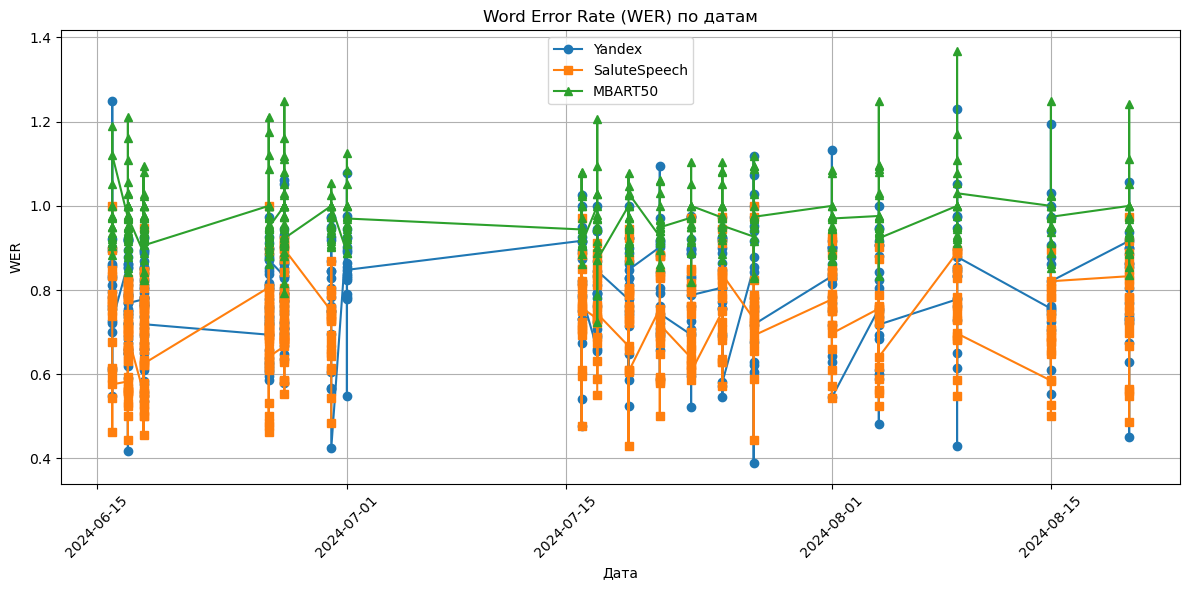

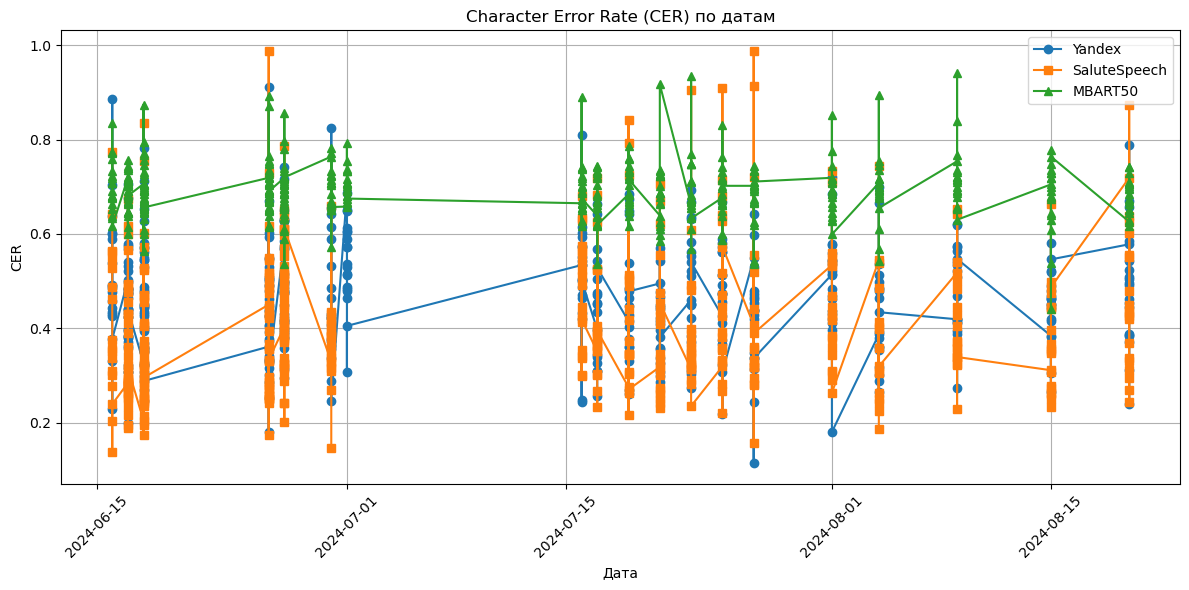

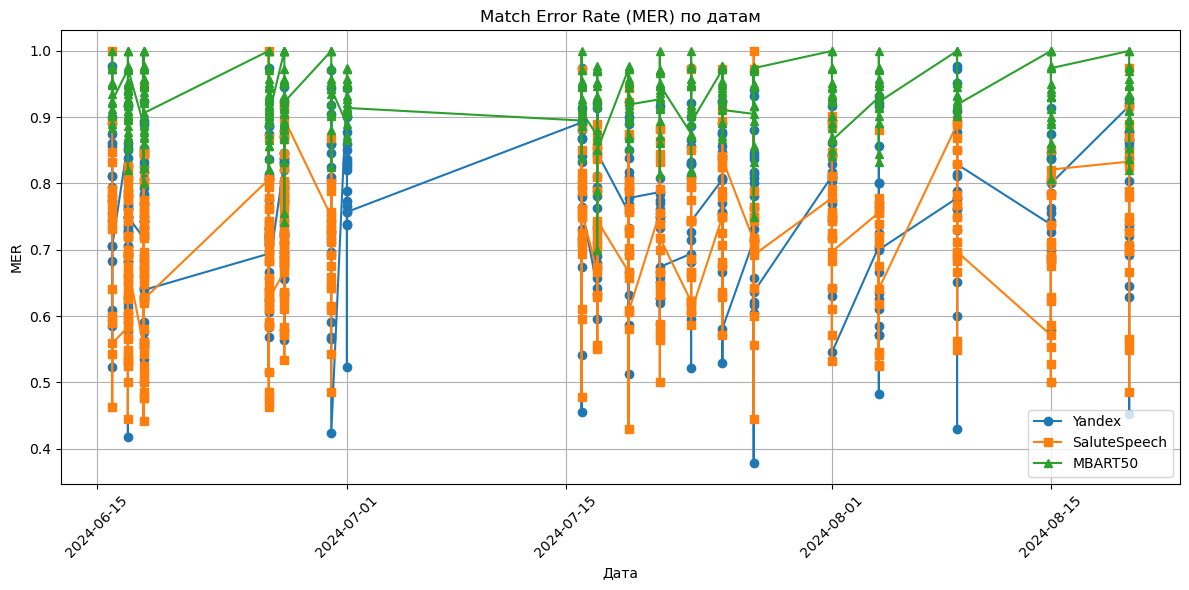

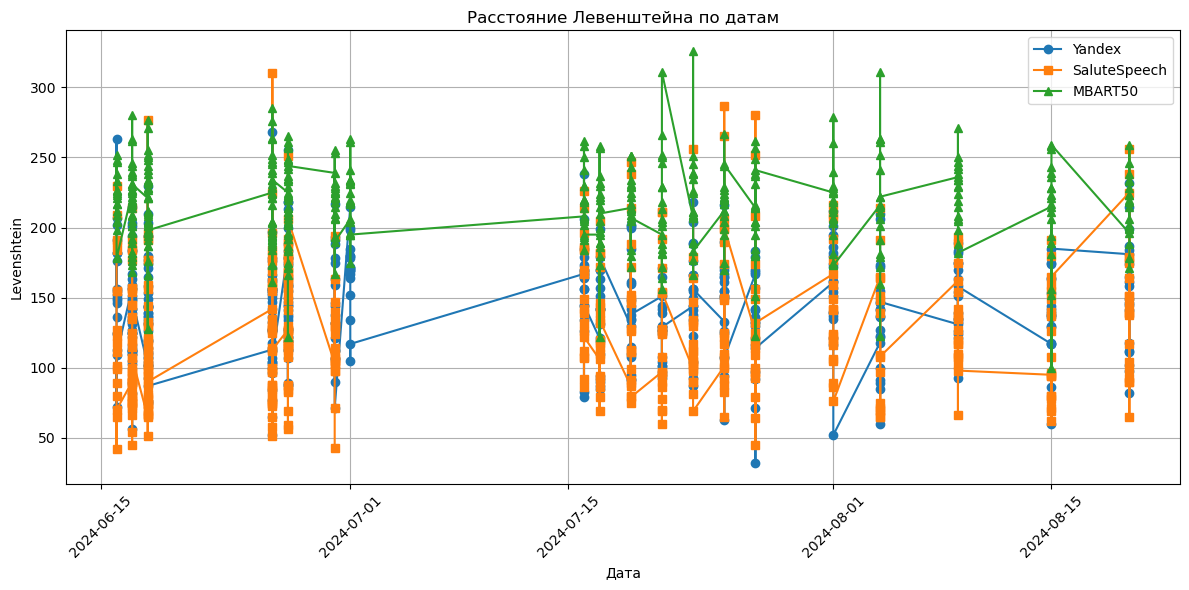

In [68]:
# Построим графики для WER, CER, MER и расстояния Левенштейна
plot_metric(df_filtered, "WER", "Word Error Rate (WER) по датам")
plot_metric(df_filtered, "CER", "Character Error Rate (CER) по датам")
plot_metric(df_filtered, "MER", "Match Error Rate (MER) по датам")
plot_metric(df_filtered, "Levenshtein", "Расстояние Левенштейна по датам")

In [61]:
df_filtered.head()

,topic,paragraph_text,transcript_text_yandex,transcript_text_salutespeech,transcript_text_mbart50,voice_recording,lemmatized_text,WER_yandex,CER_yandex,MER_yandex,...,WER_salutespeech,CER_salutespeech,MER_salutespeech,WIL_salutespeech,Levenshtein_salutespeech,WER_mbart50,CER_mbart50,MER_mbart50,WIL_mbart50,Levenshtein_mbart50
record_date,,,,,,,,,,,,,,,,,,,,,
2024-06-16,Искусственный интеллект,Искусственный интеллект (ИИ) - это область ком...,Интеллект Видать трепающий челябинского интелл...,"Интеллект компьютерных наук, состоящих материа...","безопасный интеллект, дай-капитатурных наок, р...","[b'O', b'g', b'g', b'S', b'\x00', b'\x02', b'\...",искусственный интеллект ии это область компьют...,0.833,0.486,0.811,...,0.778,0.355,0.778,0.934,111.0,1.000,0.652,1.000,1.000,204.0
2024-06-16,Искусственный интеллект,Главное преимущество ИИ - способность обрабаты...,Степощепанник обрабатывает пращи о примыканиях...,None,"голубнеж тунеядцы, стипендиаты, стипендистки, ...","[b'O', b'g', b'g', b'S', b'\x00', b'\x02', b'\...",главное преимущество ии способность обрабатыва...,0.811,0.491,0.811,...,NaN,NaN,NaN,NaN,NaN,0.973,0.733,0.973,0.999,233.0
2024-06-16,Искусственный интеллект,ИИ базируется на алгоритмах машинного обучения...,Исключительный интеллект революционные техноло...,"Искусственный интеллект, революционные техноло...","здесь к счастью, интеллигенты, ловящие на них ...","[b'O', b'g', b'g', b'S', b'\x00', b'\x02', b'\...",ии базируется на алгоритмах машинного обучения...,1.250,0.886,0.978,...,1.000,0.774,1.000,1.000,230.0,0.972,0.758,0.972,0.999,225.0
2024-06-16,Веб-сокет,Веб-сокеты - это технология для обмена данными...,Технология Мы не станем выраженным равномерным...,В отличие от этой перезапросом и всякой обесп...,"ибо, посяки эти, как ты нравы, мы не таны, мы ...","[b'O', b'g', b'g', b'S', b'\x00', b'\x02', b'\...",вебсокеты это технология для обмена данными в ...,0.861,0.639,0.861,...,0.833,0.544,0.833,0.957,155.0,1.000,0.719,0.973,0.999,205.0
2024-06-16,Веб-сокет,Главное преимущество веб-сокетов - поддержка п...,Го мне прымщ тебя высек эта поддержка штейна в...,"Да, мне пришло вот это поддержка почтенного св...","голубня, прыгнув тебе, джигурка, это поддержка...","[b'O', b'g', b'g', b'S', b'\x00', b'\x02', b'\...",главное преимущество вебсокетов поддержка пост...,0.829,0.601,0.773,...,0.610,0.351,0.595,0.815,118.0,0.951,0.708,0.951,0.997,238.0


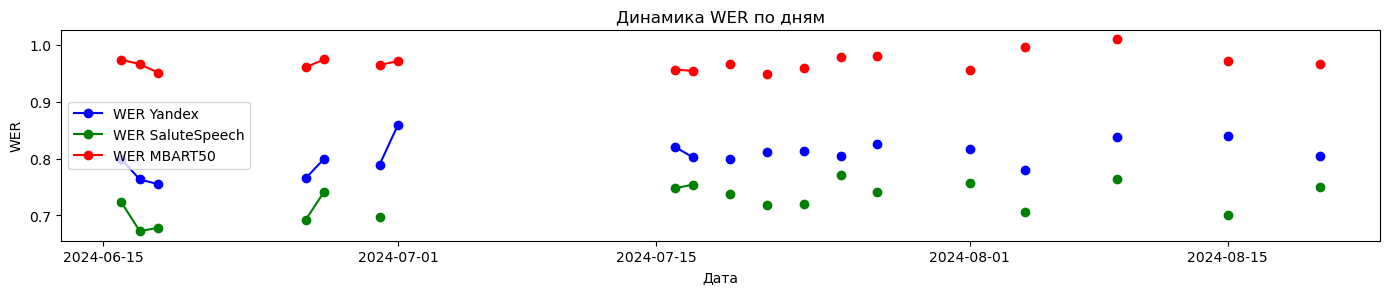

In [59]:
# Преобразуем первый уровень MultiIndex (даты) в DatetimeIndex
df_filtered.index = pd.to_datetime(df_filtered.index.get_level_values(0))

# Оставляем только числовые столбцы для агрегации
numeric_columns = df_filtered.select_dtypes(include=['float64', 'int64'])

# Агрегируем метрики по дням
daily_metrics = numeric_columns.resample('D').mean()

# Создаем графики для каждой метрики
plt.figure(figsize=(14, 8))

# График WER
plt.subplot(3, 1, 1)
plt.plot(daily_metrics.index, daily_metrics['WER_yandex'], label='WER Yandex', color='blue', marker='o')
plt.plot(daily_metrics.index, daily_metrics['WER_salutespeech'], label='WER SaluteSpeech', color='green', marker='o')
plt.plot(daily_metrics.index, daily_metrics['WER_mbart50'], label='WER MBART50', color='red', marker='o')
plt.title('Динамика WER по дням')
plt.xlabel('Дата')
plt.ylabel('WER')
plt.legend()

plt.tight_layout()
plt.show()

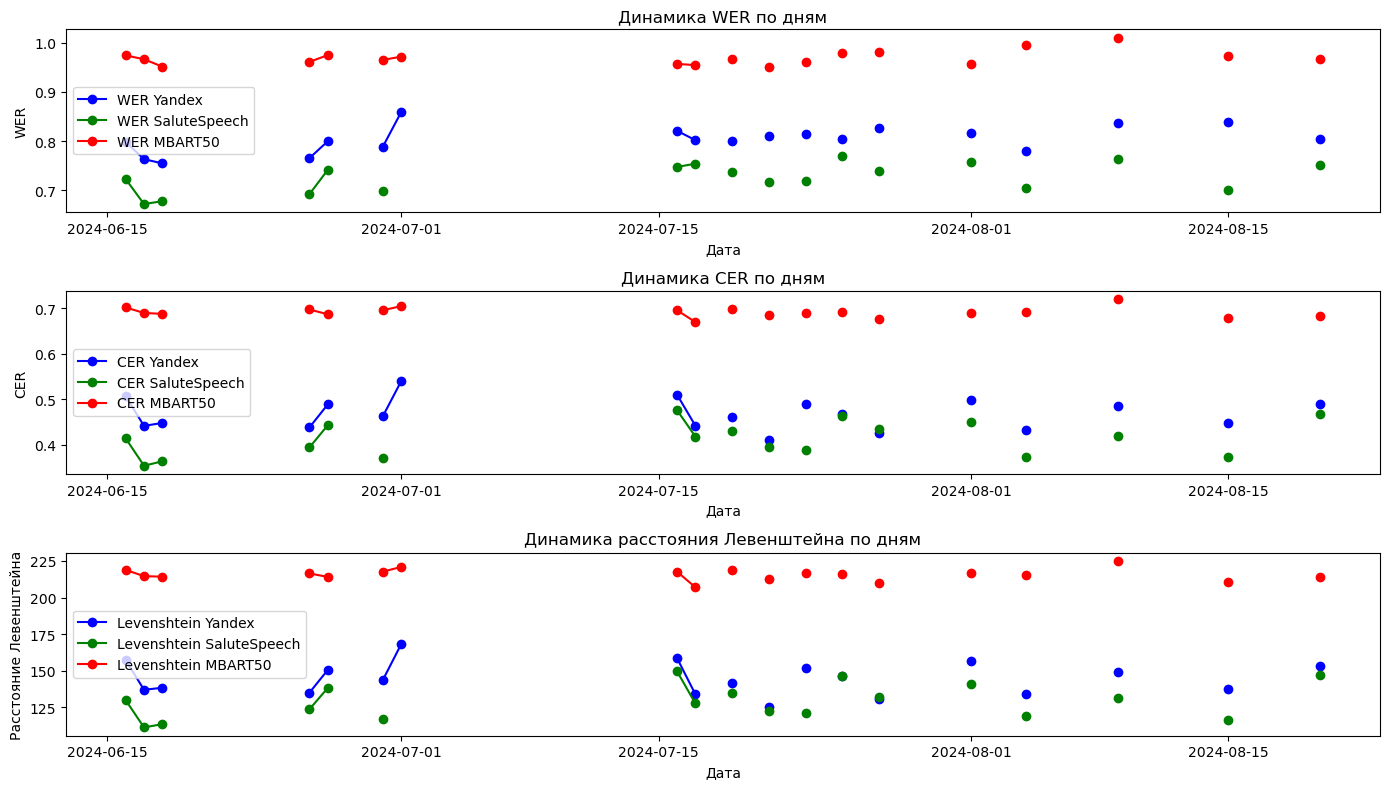

In [60]:
# Преобразуем первый уровень MultiIndex (даты) в DatetimeIndex
df_filtered.index = pd.to_datetime(df_filtered.index.get_level_values(0))

# Оставляем только числовые столбцы для агрегации
numeric_columns = df_filtered.select_dtypes(include=['float64', 'int64'])

# Агрегируем метрики по дням
daily_metrics = numeric_columns.resample('D').mean()

# Создаем графики для каждой метрики
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# График WER
plt.subplot(3, 1, 1)
plt.plot(daily_metrics.index, daily_metrics['WER_yandex'], label='WER Yandex', color='blue', marker='o')
plt.plot(daily_metrics.index, daily_metrics['WER_salutespeech'], label='WER SaluteSpeech', color='green', marker='o')
plt.plot(daily_metrics.index, daily_metrics['WER_mbart50'], label='WER MBART50', color='red', marker='o')
plt.title('Динамика WER по дням')
plt.xlabel('Дата')
plt.ylabel('WER')
plt.legend()

# График CER
plt.subplot(3, 1, 2)
plt.plot(daily_metrics.index, daily_metrics['CER_yandex'], label='CER Yandex', color='blue', marker='o')
plt.plot(daily_metrics.index, daily_metrics['CER_salutespeech'], label='CER SaluteSpeech', color='green', marker='o')
plt.plot(daily_metrics.index, daily_metrics['CER_mbart50'], label='CER MBART50', color='red', marker='o')
plt.title('Динамика CER по дням')
plt.xlabel('Дата')
plt.ylabel('CER')
plt.legend()

# График расстояния Левенштейна
plt.subplot(3, 1, 3)
plt.plot(daily_metrics.index, daily_metrics['Levenshtein_yandex'], label='Levenshtein Yandex', color='blue', marker='o')
plt.plot(daily_metrics.index, daily_metrics['Levenshtein_salutespeech'], label='Levenshtein SaluteSpeech', color='green', marker='o')
plt.plot(daily_metrics.index, daily_metrics['Levenshtein_mbart50'], label='Levenshtein MBART50', color='red', marker='o')
plt.title('Динамика расстояния Левенштейна по дням')
plt.xlabel('Дата')
plt.ylabel('Расстояние Левенштейна')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Преобразуем первый уровень MultiIndex (даты) в DatetimeIndex
df_filtered.index = pd.to_datetime(df_filtered.index.get_level_values(0))

# Оставляем только числовые столбцы для группировки и агрегации
numeric_columns = df_filtered.select_dtypes(include=['float64', 'int64'])

# Устраняем дубликаты по дате, агрегируя их средним значением
df_filtered_numeric = numeric_columns.groupby(df_filtered.index).mean()

# Агрегируем метрики по дням, заполняя пропуски
daily_metrics = df_filtered_numeric.resample('D').asfreq()

# Заполняем пропуски методом ffill (линейно от предыдущих значений)
daily_metrics = daily_metrics.fillna(method='ffill')
# Заполняем пропуски нулями
# daily_metrics = daily_metrics.fillna(0)

# Функция для создания графика динамики по метрикам для одной модели
def plot_model_metrics(model_name):
    plt.figure(figsize=(14, 10))

    # WER, CER, MER, WIL, Levenshtein
    plt.subplot(3, 1, 1)
    plt.plot(daily_metrics.index, daily_metrics[f'WER_{model_name}'], label=f'WER', marker='o')
    plt.plot(daily_metrics.index, daily_metrics[f'CER_{model_name}'], label=f'CER', marker='o')
    plt.plot(daily_metrics.index, daily_metrics[f'MER_{model_name}'], label=f'MER', marker='o')
    plt.plot(daily_metrics.index, daily_metrics[f'WIL_{model_name}'], label=f'WIL', marker='o')
    # plt.plot(daily_metrics.index, daily_metrics[f'Levenshtein_{model_name}'], label=f'Levenshtein {model_name}', marker='o')
    plt.title(f'Динамика метрик {model_name}')
    plt.xlabel('Дата')
    plt.ylabel('Значение метрики')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Построение графиков для каждой модели
models = ['yandex', 'salutespeech', 'mbart50']

for model in models:
    plot_model_metrics(model)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, linregress
from statsmodels.tsa.stattools import adfuller
import pymannkendall as mk

In [18]:
# Примерные данные
# df содержит метрики и временные ряды по каждой модели
df = pd.DataFrame({
    'date': pd.date_range(start='2024-06-16', end='2024-08-20'),
    'WER_yandex': np.random.randn(66).cumsum(),  # Пример данных
    'CER_yandex': np.random.randn(66).cumsum(),
    'MER_yandex': np.random.randn(66).cumsum(),
    'WIL_yandex': np.random.randn(66).cumsum()
})
df.set_index('date', inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66 entries, 2024-06-16 to 2024-08-20
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   WER_yandex  66 non-null     float64
 1   CER_yandex  66 non-null     float64
 2   MER_yandex  66 non-null     float64
 3   WIL_yandex  66 non-null     float64
dtypes: float64(4)
memory usage: 2.6 KB


In [19]:
df.head()

,WER_yandex,CER_yandex,MER_yandex,WIL_yandex
date,,,,
2024-06-16,-0.590799,1.455170,1.022707,1.166053
2024-06-17,0.483218,2.059047,0.910942,0.999006
2024-06-18,0.449064,1.733980,-0.010890,2.002810
2024-06-19,1.077255,2.414506,1.185152,1.329092
2024-06-20,1.590082,1.642336,-0.467905,2.194295


In [5]:
# 1. Корреляция Пирсона между временем и каждой метрикой
def pearson_analysis(df, metric):
    time_indices = np.arange(len(df))  # временной индекс
    corr, p_value = pearsonr(time_indices, df[metric].values)
    print(f"Корреляция Пирсона для {metric}: {corr:.2f}, p-value: {p_value:.2f}")
    return corr, p_value

# Пример для метрики WER_yandex
pearson_analysis(df, 'WER_yandex')

Корреляция Пирсона для WER_yandex: -0.44, p-value: 0.00


(-0.43767411039564097, 0.00023787879352579847)

In [6]:
# 2. Линейная регрессия для выявления тренда
def linear_regression_analysis(df, metric):
    time_indices = np.arange(len(df))
    slope, intercept, r_value, p_value, std_err = linregress(time_indices, df[metric])
    print(f"Линейная регрессия для {metric}: наклон: {slope:.4f}, R^2: {r_value**2:.2f}, p-value: {p_value:.4f}")
    return slope, intercept, r_value**2, p_value

# Пример для метрики WER_yandex
linear_regression_analysis(df, 'WER_yandex')

Линейная регрессия для WER_yandex: наклон: -0.0508, R^2: 0.19, p-value: 0.0002


(-0.05081754895249331,
 1.499755400349521,
 0.19155862691061556,
 0.0002378787935257998)

In [7]:
# 3. Тест Манна-Кендалла для монотонной тенденции
def mann_kendall_test(df, metric):
    result = mk.original_test(df[metric].values)
    print(f"Манн-Кендалл тест для {metric}: {result.trend}, p-value: {result.p:.4f}, z: {result.z:.4f}")
    return result

# Пример для метрики WER_yandex
mann_kendall_test(df, 'WER_yandex')

Манн-Кендалл тест для WER_yandex: decreasing, p-value: 0.0036, z: -2.9109


Mann_Kendall_Test(trend='decreasing', h=True, p=0.0036034465155132533, z=-2.910938747519873, Tau=-0.2456876456876457, s=-527.0, var_s=32651.666666666668, slope=-0.05172957079710756, intercept=1.4392035836948414)

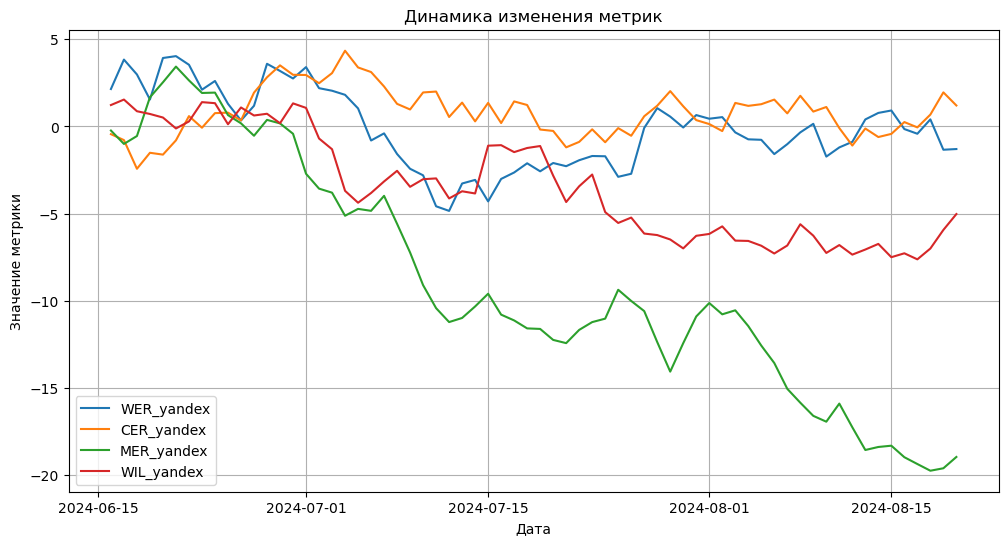

In [8]:
# 4. Визуализация динамики метрик
def plot_metrics(df, metrics):
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(df.index, df[metric], label=metric)
    plt.xlabel('Дата')
    plt.ylabel('Значение метрики')
    plt.title('Динамика изменения метрик')
    plt.legend()
    plt.grid(True)
    plt.show()

# Отображаем динамику по метрикам Yandex
metrics_yandex = ['WER_yandex', 'CER_yandex', 'MER_yandex', 'WIL_yandex']
plot_metrics(df, metrics_yandex)